In [16]:
import cv2
import PIL
import kornia
import glob
import torch
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from torchvision import transforms as T
from networks.ResnetFaceSTN import ResnetFaceSTN

In [17]:
class RowImage:
    def __init__(self, resize_dim=None):
        self.imgs = []
        self.resize_dim = resize_dim
        
    def add_img(self, img):
        if isinstance(self.resize_dim, tuple):
            img = cv2.resize(img, self.resize_dim, 
                             interpolation = cv2.INTER_AREA) 
        
        if len(self.imgs) == 0:
            self.imgs = img
        else:
            self.imgs = np.hstack((self.imgs, img))
            
    def get_row_img(self):
        return self.imgs
    
    def __call__(self):
        return self.imgs

## Transform Definitions

In [2]:
class Transform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Affine(
                scale=(0.8, 1.2),
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                order=[0, 1],
                mode='edge'
            ),
            iaa.Resize({"height": 128, "width": 128})
        ])

    def __call__(self, img):
        img = np.asarray(img)
        return self.aug.augment_image(img)

transform_train = T.Compose([
    Transform(),
    T.ToTensor(),
    T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [3]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

    
transform = T.Compose(
    [
        T.Resize((128, 128)),
        T.ToTensor(),
        T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ]
)

## Natural Sorting

In [4]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

## Weight Paths and Image Paths
Weight paths

In [6]:
w_glob = "weights/mask_exp19-resnetSTN/epoch_*/mask_exp19-resnetSTN_ep*.pth"
wpaths = glob.glob(w_glob)
wpaths.sort(key=natural_keys)
wpaths = wpaths[2:20:3]

weight_count = len(wpaths)

print(wpaths)
print(weight_count)

['weights/mask_exp19-resnetSTN/epoch_3/mask_exp19-resnetSTN_ep3.pth', 'weights/mask_exp19-resnetSTN/epoch_6/mask_exp19-resnetSTN_ep6.pth', 'weights/mask_exp19-resnetSTN/epoch_9/mask_exp19-resnetSTN_ep9.pth', 'weights/mask_exp19-resnetSTN/epoch_12/mask_exp19-resnetSTN_ep12.pth', 'weights/mask_exp19-resnetSTN/epoch_15/mask_exp19-resnetSTN_ep15.pth', 'weights/mask_exp19-resnetSTN/epoch_18/mask_exp19-resnetSTN_ep18.pth']
6


Image paths

In [7]:
sample_images = glob.glob('image_samples/LFW-Masked/*.jpg')
sample_images.sort(key=natural_keys)
print(sample_images)

['image_samples/LFW-Masked/Aaron_Eckhart_0001.jpg', 'image_samples/LFW-Masked/Abner_Martinez_0001.jpg', 'image_samples/LFW-Masked/Andy_Perez_0001.jpg', 'image_samples/LFW-Masked/Anne_Cavers_0001.jpg', 'image_samples/LFW-Masked/Cristina_Saralegui_0002.jpg']


## Preview

['3', '6', '9', '12', '15', '18']


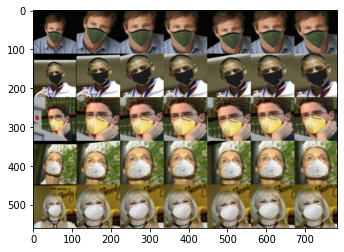

In [23]:
torch.set_printoptions(precision=10)
np.set_printoptions(suppress=True)

row = 1
col = weight_count + 1
start_2 = col + 1
ep_start = 1
# eps = [i for i in range(ep_start, ep_start+weight_count)]
eps = ['3', '6', '9', '12', '15', '18']
print(eps)

row_imgs = [RowImage(resize_dim=(112, 112)) for i in range(5)]

net = ResnetFaceSTN(stn_mode='resnet')
unorm = UnNormalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])

for n, img_path in enumerate(sample_images, 1):
    img = PIL.Image.open(img_path)
    img_t = transform(img).unsqueeze(0)

    img_p = kornia.tensor_to_image(unorm(img_t.clone().detach()))

#     plt.figure() #figsize=(3 * col, 5)
#     plt.subplot(row, col, 1)
#     plt.imshow(np.asarray(img_p))
#     plt.tight_layout()
    row_imgs[n-1].add_img(img_p)

    for i, weight in enumerate(wpaths, 2):
        net.load_state_dict(torch.load(weight))
        net.eval()

        with torch.no_grad():
            img_t2 = img_t.clone().detach()

            img_stn = net.stn(img_t2)
            img_p = kornia.tensor_to_image(unorm(img_stn.clone().detach()))
            
            row_imgs[n-1].add_img(img_p)

#             plt.subplot(row, col, i)
#             plt.xlabel(f'ep {eps[i-2]}')
#             plt.yticks([])
#             plt.imshow(np.asarray(img_p))
#             plt.tight_layout()
            
        img = PIL.Image.open(img_path)
    
#     plt.tight_layout()
#     plt.subplots_adjust(left=None, bottom=0., right=None, top=None, wspace=0., hspace=0.)
#     plt.show()

fig = np.vstack([r() for r in row_imgs])
plt.imshow(fig)
plt.show()
plt.imsave("pair_sample_result/stn_epoch_comparison.jpg", fig)